In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Đọc file dữ liệu

In [2]:
df = pd.read_pickle(
    r"D:\Project1\tracking-barbell-exercises\data\interim\03_data_features.pkl"
)

In [3]:
df.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'participant',
       'label', 'category', 'set',
       ...
       'gyr_r_pse', 'gyr_r_freq_0.0_Hz_ws_16', 'gyr_r_freq_0.781_Hz_ws_16',
       'gyr_r_freq_1.562_Hz_ws_16', 'gyr_r_freq_2.344_Hz_ws_16',
       'gyr_r_freq_3.125_Hz_ws_16', 'gyr_r_freq_3.906_Hz_ws_16',
       'gyr_r_freq_4.688_Hz_ws_16', 'gyr_r_freq_5.469_Hz_ws_16',
       'gyr_r_freq_6.25_Hz_ws_16'],
      dtype='object', length=127)

In [4]:
# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.facecolor"] = 'white'  
plt.rcParams["figure.facecolor"] = 'white'

# 2. Chia dữ liệu

## 2.1. Chia tập huấn luyện và tập kiểm định

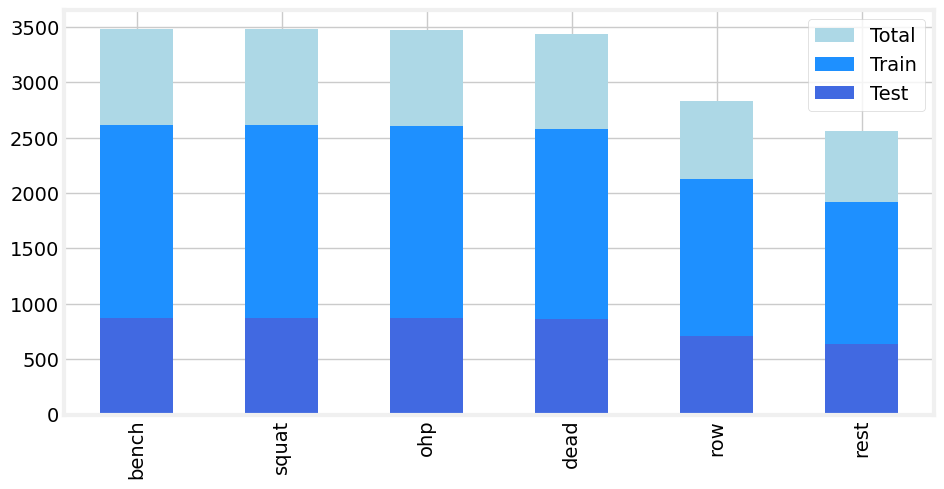

In [5]:
df_train = df.drop(["participant", "category", "set"], axis=1)

X = df_train.drop("label", axis=1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14446 entries, 2019-01-12 16:24:39 to 2019-01-19 17:12:36.440000
Columns: 123 entries, acc_x to gyr_r_freq_6.25_Hz_ws_16
dtypes: float64(123)
memory usage: 13.7 MB


## 2.2. Chia tập đặc trưng

In [7]:
basic_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
square_features = ["acc_r", "gyr_r"]
pca_features = ["pc_1", "pc_2", "pc_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
freq_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]

print("Basic features:", len(basic_features))
print("Square features:", len(square_features))
print("PCA features:", len(pca_features))
print("Time features:", len(time_features))
print("Frequency features:", len(freq_features))

feature_set_1 = list(set(basic_features))
feature_set_2 = list(set(basic_features + square_features + pca_features + time_features + freq_features))

Basic features: 6
Square features: 2
PCA features: 3
Time features: 16
Frequency features: 96


## 2.3 Lựa chọn đặc trưng

In [58]:
learner = ClassificationAlgorithms()
max_features = 12
selected_features, ordered_features, ordered_scores = learner.forward_selection(
    max_features=max_features, X_train=X_train, y_train=y_train
)

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
selected_features

In [61]:
ordered_scores

[0.9424062024089713,
 0.987055240204901,
 0.9975079606811574,
 0.9995846601135262,
 0.9998615533711754,
 0.9999307766855877,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, max_features + 1, 1), ordered_scores)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, max_features + 1, 1))
plt.show()

In [9]:
selected_features = [
 'acc_y_temp_mean_ws_35',
 'acc_y_temp_std_ws_35',
 'acc_x_temp_mean_ws_35',
 'acc_z_temp_mean_ws_35',
 'gyr_y_freq_0.0_Hz_ws_16'
 ]

# 3. Huấn luyện mô hình

## 3.1 Lựa chọn mô hình

In [10]:
learner = ClassificationAlgorithms()
score_df = pd.DataFrame()

possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    selected_features
]

for i in range (len(possible_feature_sets)):
    print(f'Tập đặc trưng số {i+1}:')
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]


    # First run non deterministic classifiers to average their score.
    print("\tTraining neural network")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
        nn,
    ) = learner.feedforward_neural_network(
        selected_train_X,
        y_train,
        selected_test_X,
        gridsearch=False,
    )
    acc_nn = accuracy_score(y_test, class_test_y)
    p_nn = precision_score(y_test, class_test_y, average='macro')
    r_nn = recall_score(y_test, class_test_y, average='macro')
    f1_nn = f1_score(y_test, class_test_y, average='macro')

    print("\tTraining random forest")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
        rf,
    ) = learner.random_forest(
        selected_train_X, 
        y_train, 
        selected_test_X, 
        gridsearch=True, 
    )
    acc_rf = accuracy_score(y_test, class_test_y)
    p_rf = precision_score(y_test, class_test_y, average='macro')
    r_rf = recall_score(y_test, class_test_y, average='macro')
    f1_rf = f1_score(y_test, class_test_y, average='macro')

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
        knn,
    ) = learner.k_nearest_neighbor(
        selected_train_X, 
        y_train, 
        selected_test_X, 
        gridsearch=True,
    )
    acc_knn = accuracy_score(y_test, class_test_y)
    p_knn = precision_score(y_test, class_test_y, average='macro')
    r_knn = recall_score(y_test, class_test_y, average='macro')
    f1_knn = f1_score(y_test, class_test_y, average='macro')

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
        dtree,
    ) = learner.decision_tree(
        selected_train_X, 
        y_train, 
        selected_test_X, 
        gridsearch=True,
    )
    acc_dtree = accuracy_score(y_test, class_test_y)
    p_dtree = precision_score(y_test, class_test_y, average='macro')
    r_dtree = recall_score(y_test, class_test_y, average='macro')
    f1_dtree = f1_score(y_test, class_test_y, average='macro')

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
        nb,
    ) = learner.naive_bayes(
        selected_train_X, 
        y_train, 
        selected_test_X,
        )
    acc_nb = accuracy_score(y_test, class_test_y)
    p_nb = precision_score(y_test, class_test_y, average='macro')
    r_nb = recall_score(y_test, class_test_y, average='macro')
    f1_nb = f1_score(y_test, class_test_y, average='macro')

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "accuracy": [
                acc_nn,
                acc_rf,
                acc_knn,
                acc_dtree,
                acc_nb,
            ],
            "precision": [
                p_nn,
                p_rf,
                p_knn,
                p_dtree,
                p_nb,
            ],
            "recall": [
                r_nn,
                r_rf,
                r_knn,
                r_dtree,
                r_nb,
            ],
            "f1 score": [
                f1_nn,
                f1_rf,
                f1_knn,
                f1_dtree,
                f1_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Tập đặc trưng số 1:
	Training neural network
	Training random forest
	Training KNN
	Training decision tree
	Training naive bayes
Tập đặc trưng số 2:
	Training neural network
	Training random forest
	Training KNN
	Training decision tree
	Training naive bayes
Tập đặc trưng số 3:
	Training neural network
	Training random forest
	Training KNN
	Training decision tree
	Training naive bayes


In [11]:
score_df

,model,accuracy,precision,recall,f1 score
0,NN,0.938953,0.941432,0.940412,0.940822
1,RF,0.969477,0.970332,0.971176,0.970618
2,KNN,0.840532,0.844605,0.849860,0.845888
3,DT,0.949751,0.951848,0.951581,0.951629
4,NB,0.823297,0.830519,0.822069,0.820517
0,NN,0.992317,0.992569,0.992857,0.992701
1,RF,0.997093,0.997344,0.997320,0.997316
2,KNN,0.983804,0.984390,0.984898,0.984544
3,DT,0.998339,0.998472,0.998469,0.998467
4,NB,0.956395,0.958460,0.959254,0.958777


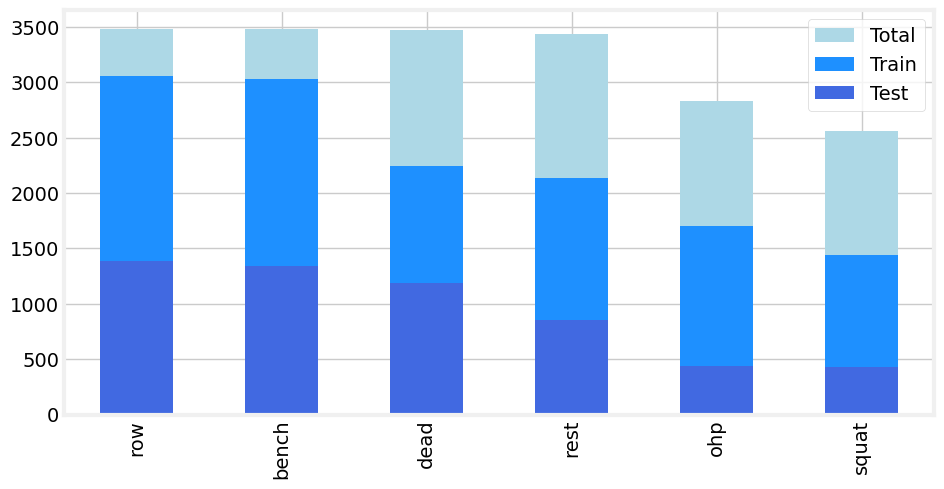

In [16]:
participant_df = df.drop(["set", "category"], axis=1)

X_train = participant_df[participant_df["participant"] != "E"].drop("label", axis=1)
y_train = participant_df[participant_df["participant"] != "E"]["label"]

X_test = participant_df[participant_df["participant"] == "E"].drop("label", axis=1)
y_test = participant_df[participant_df["participant"] == "E"]["label"]

X_train = X_train.drop(["participant"], axis=1)
X_test = X_test.drop(["participant"], axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)
y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()

Model saved to D:\\Project1\\tracking-barbell-exercises\\models\\random_forest.joblib


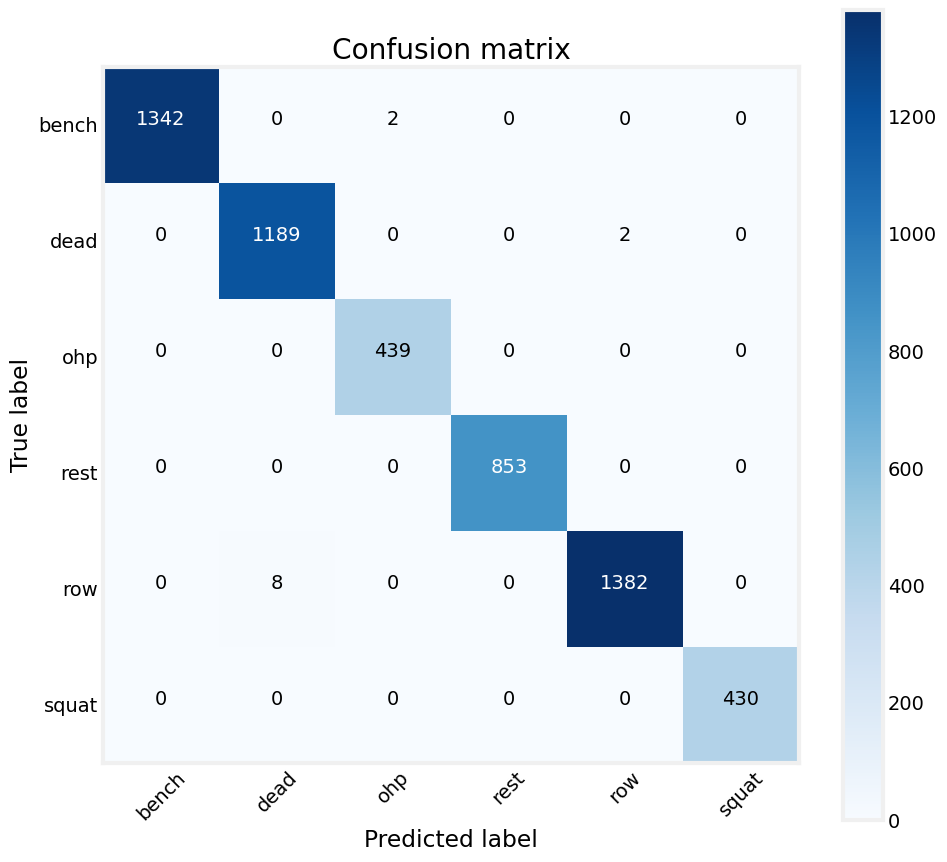

In [17]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
    rf,
) = learner.random_forest(
    X_train[selected_features], 
    y_train, 
    X_test[selected_features], 
    gridsearch=True,
    model_save_path=r"D:\\Project1\\tracking-barbell-exercises\\models\\random_forest.joblib",
)

accuracy = accuracy_score(y_test, class_test_y)
precision = precision_score(y_test, class_test_y, average='macro')
recall = recall_score(y_test, class_test_y, average='macro')
f1 = f1_score(y_test, class_test_y, average='macro')

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

In [18]:
score = [accuracy, precision, recall, f1]
score

[0.9978749778643528, 0.9978893984663467, 0.998512874658891, 0.9981983606219006]